In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# 使用上传文件的路径来读取Excel文件
d = pd.read_csv('话单10-27--11-12.csv')
d['ring_length'] = d['call_length'] - d['talk_length']

In [2]:
campaign_counts = d['campaign_id'].value_counts()

# 打印结果
print(campaign_counts)

165e1a5d0fbe4c1ca29098a69bb1f26f    158827
ace4a9a4139f4e6a9d2610f8b9c5c977    100326
296b2f40d0e64a90b4dce938c07829d7     92286
6a13f30dd7214f8b8241d098c9258779     69147
511f954e1d8b42b1bd28cbb67ad3ffdb     57857
579065d4382346f2a2ab05fd82add084     24957
3baea26182f5416b82e89a0762c91ead      7005
7ea108235907472ba1aed2532ae199ab      6023
Name: campaign_id, dtype: int64


In [3]:
df_dict = {}
n = 1  # 用于生成递增的键

for id in campaign_counts.keys():
    # 根据当前 id 筛选出对应的行
    dfn = d[d['campaign_id'] == id]
    # 使用 n 作为字典的键
    df_dict[f'df{n}'] = dfn
    n += 1  # 递增 n

In [4]:
for n in df_dict:
    df_dict[n] = df_dict[n][['result_code', 'ring_length', 'talk_length']]
    
    # 输出行数
    print(f"{n} 的行数: {len(df_dict[n])}")

df1 的行数: 158827
df2 的行数: 100326
df3 的行数: 92286
df4 的行数: 69147
df5 的行数: 57857
df6 的行数: 24957
df7 的行数: 7005
df8 的行数: 6023


In [5]:
def prepare_call_states(dfn):
    """
    准备通话状态数据，基于振铃时间和通话时间生成每秒的状态。
    :param dfn: DataFrame 包含 'ring_length' 和 'talk_length' 列
    :return: 包含通话状态的列表
    """
    call_states = []
    
    for index, row in dfn.iterrows():
        ring_length_seconds = int(math.ceil(row['ring_length']))  # 向上取整振铃时间
        talk_length_seconds = int(math.ceil(row['talk_length']))  # 向上取整通话时间

        # 对于振铃阶段每一秒的状态
        for second in range(ring_length_seconds):
            call_states.append({
                'call_id': index,
                'second': second,
                'state': 'ringing'
            })
        # 如果在振铃阶段接通，则标记为 'answered'
        if ring_length_seconds > 0 and talk_length_seconds != 0:
            call_states.append({
                'call_id': index,
                'second': ring_length_seconds,
                'state': 'answered'
            })
        # 如果在振铃阶段被挂断（未接通），则标记为 'disconnected'
        elif ring_length_seconds > 0 and talk_length_seconds == 0:
            call_states.append({
                'call_id': index,
                'second': ring_length_seconds,
                'state': 'disconnected'
            })
    
    return call_states

In [6]:
def calculate_state_counts(call_states):
    """
    根据通话状态计算每秒的状态数量。
    :param call_states: 通话状态的列表
    :return: 一个 DataFrame，显示每秒的状态数量
    """
    if not call_states:
        return pd.DataFrame()

    call_states_df = pd.DataFrame(call_states)
    state_counts_by_second = call_states_df.groupby(['second', 'state'])['call_id'].count().unstack(fill_value=0)
    
    return state_counts_by_second

In [9]:
def calculate_transition_probabilities(state_counts_by_second):
    """
    计算每秒从振铃状态转移到接通状态的概率。
    :param state_counts_by_second: 每秒的状态数量 DataFrame
    :return: 包含每秒接通概率的 DataFrame
    """
    prob_df = pd.DataFrame(columns=['second', 'ringing_count', 'answered_next_second_count', 'prob_answered_next_second'])

    seconds = sorted(state_counts_by_second.index)
    for i in range(len(seconds) - 1):
        current_second = seconds[i]
        next_second = seconds[i + 1]

        ringing_count = state_counts_by_second.at[current_second, 'ringing'] if 'ringing' in state_counts_by_second.columns else 0
        if ringing_count == 0:
            continue

        answered_next_second = state_counts_by_second.at[next_second, 'answered'] if 'answered' in state_counts_by_second.columns else 0
        prob_answered_next_second = answered_next_second / ringing_count if ringing_count else 0.0

        
        # 创建一个新的DataFrame来包含要追加的数据
        new_row = pd.DataFrame({
            'second': [current_second],
            'ringing_count': [ringing_count],
            'answered_next_second_count': [answered_next_second],
            'prob_answered_next_second': [prob_answered_next_second]
        })

        # 使用 concat 将新的行追加到 prob_df
        prob_df = pd.concat([prob_df, new_row], ignore_index=True)
        
        #prob_df = prob_df.append({
         #   'second': current_second,
          #  'ringing_count': ringing_count,
           # 'answered_next_second_count': answered_next_second,
            #'prob_answered_next_second': prob_answered_next_second
        #}, ignore_index=True)
    
    return prob_df

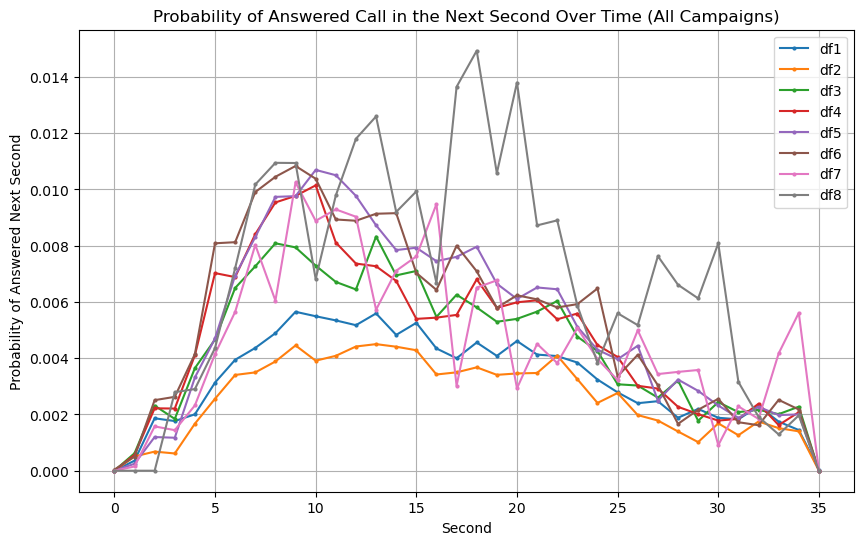

In [10]:
plt.figure(figsize=(10, 6))
for n in df_dict:
    dfn = df_dict[n]
    
    if dfn.empty:
        continue
    
    # 调用函数生成通话状态、状态数量、转移概率
    call_states = prepare_call_states(dfn)
    state_counts_by_second = calculate_state_counts(call_states)
    prob_df = calculate_transition_probabilities(state_counts_by_second)
    
    # 在同一图中绘制每个 DataFrame 的曲线
    if not prob_df.empty:
        plt.plot(prob_df['second'], prob_df['prob_answered_next_second'], marker='o', label=n, markersize=2)

# 图表设置
plt.xlabel('Second')
plt.ylabel('Probability of Answered Next Second')
plt.title('Probability of Answered Call in the Next Second Over Time (All Campaigns)')
plt.grid(True)
plt.legend()  # 显示图例，区分不同的 DataFrame
plt.show()